In [1]:
import json
import numpy as np
from scipy.spatial.distance import pdist
import random
from sklearn.model_selection import train_test_split

import math
import torch
from netCDF4 import Dataset
from torchvision import datasets
import gpytorch

from matplotlib import pyplot as plt



import math
with open('../Configs/configGAUS.json') as f:
  config = json.loads(f.read())
import random




In [2]:

database =config['config']["database"]["file"]
print(database)

data = Dataset(database, mode='r')
if config['config']["database"]["crdmode"] == "cartesian":
    dbset = np.copy(data['crd'])
    coordinatesout = []
    for j,i in enumerate(dbset):
        if j == 0:
            coordinatesout = [pdist(i)]
        else:
            coordinatesout = np.concatenate((coordinatesout,[pdist(i)]))
            
energyout =np.copy(data['energy'])-np.amin(data['energy'])     


coordinates, val_coordinates, outputtrain, val_output = train_test_split(coordinatesout, energyout , test_size=config['config']['grid_search']['validation_ratio'])




../../so2a.db


In [3]:




train_x = torch.tensor(coordinates[0,:]).to(torch.float32)
train_pre = torch.tensor(outputtrain).to(torch.float32)


train_y = torch.stack([train_pre[0,:],
                       train_pre[1,:],
                       train_pre[2,:]
  ],-1)

class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=3
        )
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            gpytorch.kernels.RBFKernel(), num_tasks=3, rank=1
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)


likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=3)
model = MultitaskGPModel(train_x, train_y, likelihood)

In [4]:


import os

training_iterations =  50


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
    optimizer.step()

Iter 1/50 - Loss: 1.450
Iter 2/50 - Loss: 1.404
Iter 3/50 - Loss: 1.360
Iter 4/50 - Loss: 1.317
Iter 5/50 - Loss: 1.273
Iter 6/50 - Loss: 1.230
Iter 7/50 - Loss: 1.189
Iter 8/50 - Loss: 1.148
Iter 9/50 - Loss: 1.108
Iter 10/50 - Loss: 1.067
Iter 11/50 - Loss: 1.026
Iter 12/50 - Loss: 0.984
Iter 13/50 - Loss: 0.942
Iter 14/50 - Loss: 0.900
Iter 15/50 - Loss: 0.857
Iter 16/50 - Loss: 0.812
Iter 17/50 - Loss: 0.766
Iter 18/50 - Loss: 0.717
Iter 19/50 - Loss: 0.667
Iter 20/50 - Loss: 0.617
Iter 21/50 - Loss: 0.567
Iter 22/50 - Loss: 0.517
Iter 23/50 - Loss: 0.467
Iter 24/50 - Loss: 0.415
Iter 25/50 - Loss: 0.363
Iter 26/50 - Loss: 0.311
Iter 27/50 - Loss: 0.260
Iter 28/50 - Loss: 0.209
Iter 29/50 - Loss: 0.155
Iter 30/50 - Loss: 0.101
Iter 31/50 - Loss: 0.047
Iter 32/50 - Loss: -0.006
Iter 33/50 - Loss: -0.060
Iter 34/50 - Loss: -0.111
Iter 35/50 - Loss: -0.163
Iter 36/50 - Loss: -0.217
Iter 37/50 - Loss: -0.272
Iter 38/50 - Loss: -0.324
Iter 39/50 - Loss: -0.376
Iter 40/50 - Loss: -0.428


RuntimeError: mean should be a matrix or a batch matrix (batch mode)

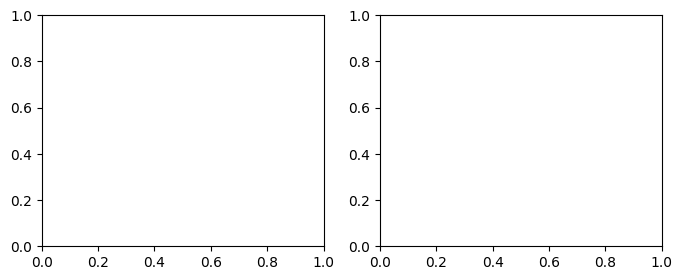

In [5]:

# Set into eval mode
model.eval()
likelihood.eval()

# Initialize plots
f, axs = plt.subplots(1, 2, figsize=(8, 3))

# Make predictions (use the same test points)
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51)
    # This contains predictions for both outcomes as a list
    predictions = likelihood(*model(test_x, test_x))

for submodel, prediction, ax in zip(model.models, predictions, axs):
    mean = prediction.mean
    lower, upper = prediction.confidence_region()

    tr_x = submodel.train_inputs[0].detach().numpy()
    tr_y = submodel.train_targets.detach().numpy()

    # Plot training data as black stars
    ax.plot(tr_x, tr_y, 'k*')
    # Predictive mean as blue line
    ax.plot(test_x.numpy(), mean.numpy(), 'b')
    # Shade in confidence
    ax.fill_between(test_x.numpy(), lower.detach().numpy(), upper.detach().numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])
    ax.set_title('Observed Values (Likelihood)')

None

In [ ]:
#test get offspring


In [ ]:
## test full routine
